<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/PINN_vdPol_controle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.integrate import solve_ivp

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.utils import plot_model

print('Versão do TensorFlow:', tf.__version__)

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
tf.random.set_seed(2024)

# Aumenta o tamanho da fonte para 14
plt.rcParams['font.size'] = 14
# Define o grid como visível
plt.rcParams['axes.grid'] = True

Versão do TensorFlow: 2.15.0


In [20]:
# prompt: create a function called parameters_to_1D_vector, which should take model.trainable_variables (weights and biases) and return a 1D vector.

def parameters_to_1D_vector(weights_and_biases):
  """
  Converts a list of weights and biases to a 1D vector.

  Args:
    weights_and_biases: A list of weights and biases.

  Returns:
    A 1D vector containing the weights and biases.
  """
  # Concatenate the weights and biases into a single vector.
  vector = tf.concat([tf.reshape(w, [-1]) for w in weights_and_biases], axis=0)
  return tf.cast(vector, tf.float32)


# prompt: create a function taking the 1D vector and update its shape to match the  model.trainable_variables.

def update_model_weights(net, weights_1D_vector):
  """
  Updates the weights and biases of the model from a 1D vector.

  Args:
    weights_1D_vector: A 1D vector containing the weights and biases.
  """
  # Split the vector into the weights and biases.
  weights_and_biases = []
  start = 0
  for w in net.trainable_variables:
    shape = w.shape
    size = tf.reduce_prod(shape)
    weights_and_biases.append(tf.reshape(weights_1D_vector[start:start + size], shape))
    start += size

  # Update the weights and biases of the model.
  for i, w in enumerate(net.trainable_variables):
    net.trainable_variables[i].assign(weights_and_biases[i])

# Sistema van der Pol

In [49]:
T = 0.5
lb = [0.0, -2.5, -3.7, -1.0]
ub = [T, 2.5, 3.7, 1.0]

def f(t, y1, y2, u):
  f1 = y2
  f2 = (1-y1**2) * y2 - y1 + u
  return tf.concat((f1,f2),1)

# Ajuste de uma PINN com entrada de condição inicial e sinal de controle.

## Criando o modelo NN

In [22]:
N_layers = 4
N_neurons = 20
model = tf.keras.Sequential()
for i in range(N_layers):
  model.add(Dense(N_neurons, activation='tanh'))
model.add(Dense(2))
model.build(input_shape=(1,4))

## Dado de treinamento da condição inicial

In [50]:
# criando a condição inicial
N_t = 1000
t_train = tf.zeros((N_t,1))
y0_train = tf.random.uniform((N_t,2), minval=lb[1:3], maxval=ub[1:3])
u_train = tf.random.uniform((N_t,1), minval=lb[3], maxval=ub[3])
v0_train = tf.concat([t_train, y0_train, u_train], axis=1)

# Usando o modelo NN
y0 = model(v0_train)

# Calculando a função de perda
MSE_y0 = tf.reduce_mean((y0-y0_train)**2)
print(MSE_y0)

tf.Tensor(0.004341141, shape=(), dtype=float32)


## Pontos de colocação

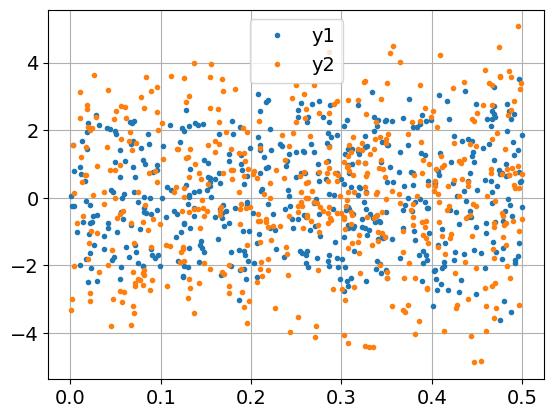

In [51]:
N_f = int(1000 * T)

# criando amostras randômicas
v_col = tf.random.uniform((N_f,4), minval=lb, maxval=ub)

# testando o modelo
y_col = model(v_col)
plt.plot(v_col[:,0], y_col, '.')
plt.legend(['y1', 'y2']);

## Calcular a perda de cada ponto de colocação

In [55]:
@tf.function
def system_loss(net, t):

    with tf.GradientTape(persistent=True) as tape:
      tape.watch(t)
      input = tf.concat([t, v_col[:,1:]], axis=1)
      output = net(input)

      y1_hat = output[:,0:1]
      y2_hat = output[:,1:2]

    y1_t = tape.gradient(y1_hat, t)
    y2_t = tape.gradient(y2_hat, t)
    del tape

    # Resíduo e perda do modelo nos pontos de colocacao
    y_t = tf.concat([y1_t, y2_t],1)
    F = y_t - f(t, y1_hat, y2_hat, v_col[:,3:4])
    MSE_F = tf.reduce_mean(F**2)

    # Predição da condição inicial
    y0_hat = net(v0_train)
    MSE_y0 = tf.reduce_mean((y0_hat-y0_train)**2)

    # Perda no treinamento
    # MSE_y = tf.reduce_mean((y_hat-y_train)**2)

    return MSE_F + MSE_y0

## Loop de treinamento: Adam com L-BFGS

In [53]:
# Define uma taxa de aprendizagem que muda ao longo do processo de treinamento
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,5000],[1e-2,1e-3,5e-4])

# Define o otimizador Adam, um algoritmo de otimização estocástica comum usado para treinar redes neurais.
# O AMSGrad é uma variante do otimizador Adam que pode oferecer algumas vantagens (estabilidade, rapidez, desempenho, ...), mas nem sempre é superior ao Adam.
optm = tf.keras.optimizers.Adam(learning_rate = lr,
                                beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

In [56]:
epochs = 10000
fun_hist = []
for i in range(epochs):
  with tf.GradientTape() as tape:
    loss = system_loss(model, v_col[:,0:1])

  gradients = tape.gradient(loss, model.trainable_variables)
  optm.apply_gradients(zip(gradients, model.trainable_variables))
  fun_hist.append(loss.numpy())


In [61]:
from scipy.optimize import fmin_l_bfgs_b

def f_val_and_grad(x):
  x = tf.cast(x, tf.float32)
  update_model_weights(model, x)

  with tf.GradientTape() as tape:
    loss = system_loss(model, v_col[:,0:1])

  gradients = tape.gradient(loss, model.trainable_variables)
  gradients_vec = parameters_to_1D_vector(gradients)
  fun_hist.append(loss.numpy())

  return loss, gradients_vec

initial_parameters = parameters_to_1D_vector(model.trainable_variables)

x = fmin_l_bfgs_b(f_val_and_grad, initial_parameters, maxiter=epochs)

Text(0, 0.5, 'Total loss')

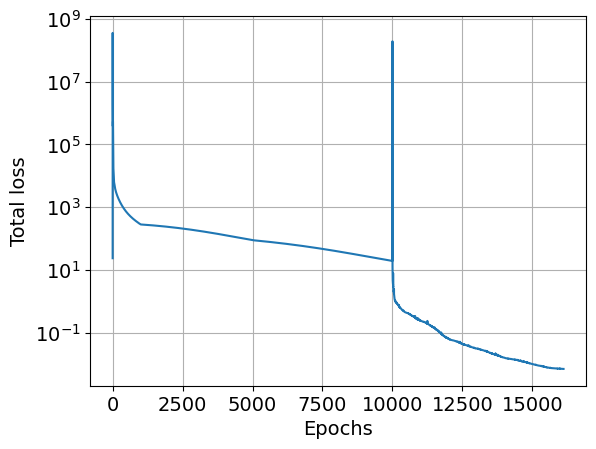

In [62]:
update_model_weights(model, tf.cast(x[0], tf.float32))

plt.plot(fun_hist)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Total loss')

In [59]:
# Usando o modelo NN
y = model(t_train)

# Calculando a função de perda
MSE_y0 = tf.reduce_mean((y-y_train)**2)
print(y.numpy(), y_train.numpy(), MSE_y0.numpy())

ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).

Input 0 of layer "dense_5" is incompatible with the layer: expected axis -1 of input shape to have value 4, but received input with shape (1000, 1)

Call arguments received by layer 'sequential_1' (type Sequential):
  • inputs=tf.Tensor(shape=(1000, 1), dtype=float32)
  • training=None
  • mask=None

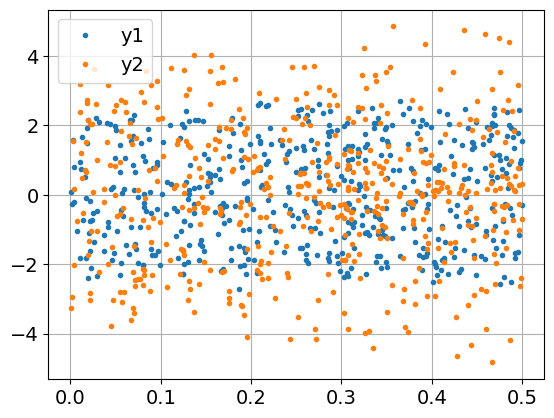

In [63]:
# testando o modelo
y_collocation = model(v_col)
plt.plot(v_col[:,0], y_collocation, '.')
plt.legend(['y1', 'y2']);

## Simulando com solve_ivp

In [ ]:
def f_ivp(t, x, u):
  y1, y2 = x
  f1 = y2
  f2 = (1-y1**2) * y2 - y1 + u
  return [f1,f2]

# intervalo de integração
tspan = [0, 10]
time = np.linspace(*tspan, 21)

# condição inicial
x0 = [0.3, -1.5]
u0 = 0.5

# instanciando o modelo
model = lambda t, x: f_ivp(t, x, u0)

# obtendo resultados
sol = solve_ivp(model, tspan, x0, method='BDF')

ts = sol.t
x = sol.y

# visualizando os pontos
plt.plot(t_collocation, y_collocation, 'o')
plt.plot(ts, x[0,:], '--')
plt.plot(ts, x[1,:], '--')
plt.xlabel('Time [s]');